In [1]:
import mlflow
import shutil
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pathlib import Path
from mlflow.pyfunc import PythonModel

%matplotlib inline

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/deivith/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#create my temporal folder
os.makedirs("tmp")

In [3]:
## setup my experiment
mlflow.set_tracking_uri("http://localhost:5000")
experiment_id = mlflow.create_experiment("Models exercise",
                                      tags={"version": "v1", "priority": "P1","project_name": "Persist artifacts"})

print(experiment_id)

2


In [3]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Models exercise")

<Experiment: artifact_location='/home/deivith/Documentos/cursos/mlflow/plural/tmpServer/2', creation_time=1718056375471, experiment_id='2', last_update_time=1718056375471, lifecycle_stage='active', name='Models exercise', tags={'priority': 'P1', 'project_name': 'Persist artifacts', 'version': 'v1'}>

In [4]:
## Upload my data
if os.path.exists("./data/dataframe.csv"):
    print("file exists")
    df = pd.read_csv("./data/data_selected.csv")
else:
    print("files doesn't exists")
    data = pd.read_csv("./data/AmesHousing.csv")
    features = ['Lot Area', 'Gr Liv Area', 'Garage Area', 'Bldg Type']
    target = ['SalePrice']
    df = data.loc[:, features + target]

files doesn't exists


In [5]:
## obtain the features names and target name
features_columns = features = ['Lot Area', 'Gr Liv Area', 'Garage Area', 'Bldg Type']
target_column = ['SalePrice']
cat_features = ['Bldg Type']

In [43]:
"""
for col, uni in df[cat_features.items():
    print(f'col = {col}')
    print(f'uni = {uni.unique()}')
"""
value = df[cat_features]
print(type(value))

<class 'pandas.core.frame.DataFrame'>


In [57]:
ct = pd.DataFrame({"bob": ["1","2"]})
for a, b in ct.items():
    for aa in b:
        print(aa)

1
2


In [6]:
class WrapperLRModel(PythonModel):
    def __init__(self, sklearn_model_features, categorical_names, model_artifact_name):
        """
        categorical_names: Mapping from categorical features names to all
        possible values, e.g.:
        {
            "Bldg Type": ["1Fam", "TwnhsE", ...]
        }
        """
        self.features_names = sklearn_model_features
        self.categorical_names = categorical_names
        self.model_artifact_name = model_artifact_name

    def load_contest(self, context):
        with open(context.artifacts[self.model_artifact_name], "rb") as m:
            self.lr_model = pickle.load(m)

    def _encode(row, colname):
        value = row[colname]
        row[value] = 1
        return row

    def predict(self, context, model_input):
        model_features = model_input
        for col, unique_values in self.categorical_names.items():
            for value in unique_value:
                model_features[value] = 0
            model_features = model_features.apply(lambda row: self._encode(row, col), axis=1)
        model_features = model_features.loc[:, self.features_names]
        return self.lr_model.predict(model_features.to_numpy())
            

In [7]:
def prepare_data(dataframe:pd.DataFrame) -> pd.DataFrame:
    """
    input: Dataframe
    output: Dataframe
    
    this function transforms the cateforical values in numeric values using one hot encoder
    """
    df = dataframe
    categorical_features_names = {}
    for col in list(dataframe.columns):
        if col in cat_features:
            categorical_features_names[col] = list(df[col].unique())
            dummies = pd.get_dummies(df[col])
            df = pd.concat([df.drop([col], axis=1), dummies], axis=1)
    df = df.fillna(0)
    return df, categorical_features_names

In [12]:
def train_and_evaluate(dataframe:pd.DataFrame, categorical_features_names:dict) -> None:
    """
    input:  DataFrame is the features
            target is the target
    this function trains models and evaluates them using mean squared error
    """
    features = dataframe.drop(target_column, axis=1)    
    target = dataframe.loc[:, target_column]
    X_train, X_test, y_train, y_test = train_test_split(features.to_numpy(), target.to_numpy(), test_size=0.2, random_state=12)

    #create plots
    plot = dataframe.plot.scatter(x=0, y='SalePrice')
    fig = plot.get_figure()
    fig.savefig("tmp/plot.png")
    
    #save the dataframe selected
    dataframe.to_csv("tmp/dataset.csv", index=False)
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    #save the model
    ## this was implemented for multiples runs but for model registration it is not necesary
    ## but for cusmotize model i need have the serializated model
    serialized_model = pickle.dumps(model)
    with open("./tmp/model.pkl", "wb+") as mo:
        mo.write(serialized_model)

    #mlflow.log_artifacts("tmp")

    #model registration using the sklearn flavor
    # this was changed for customize model registration
    #mlflow.sklearn.log_model(model, 'lr_model')
    model_artifact_name = 'LinearRegressionModel'
    model_artifacts = {
        model_artifact_name:"tmp/model.pkl"
    }

    mlflow.pyfunc.log_model(
        "custom model",
        python_model=WrapperLRModel(sklearn_model_features=list(features.columns),
                                    categorical_names=categorical_features_names, 
                                    model_artifact_name=model_artifact_name),
        artifacts=model_artifacts,
        registered_model_name="Model_register",
        alias="experiment"
        
    )
        
    mlflow.log_artifacts("tmp")

    y_pred = model.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    #print(f' the error was = {error}')
    mlflow.log_metric("MSE", error)

2033dea5daae4a199efd2139fabdb8bf
2686623332.3754606
f787fdc3018247a18b8f3695570b1e03
3980909422.5511055
283bc442c5f04b898101950089f06693
3305431659.35769
30b09af2263a44eda6b62ebfc5392878
2854716346.360011
c27807a8f60b42ddac8d2129910fe061
2662507570.636743


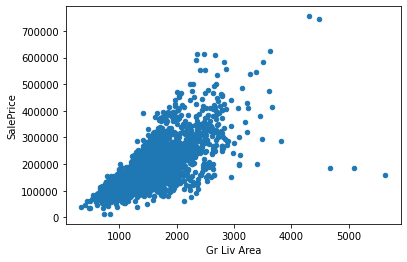

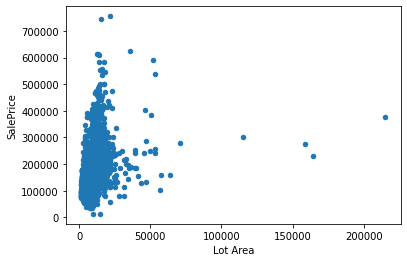

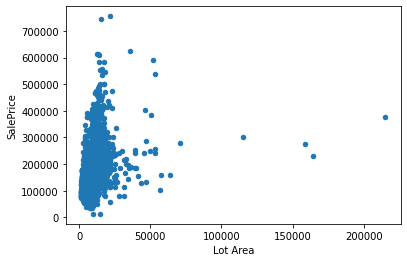

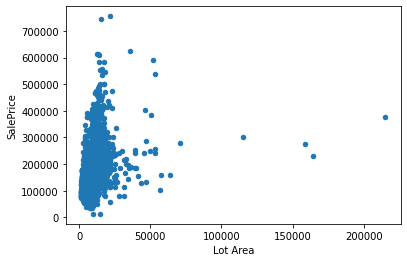

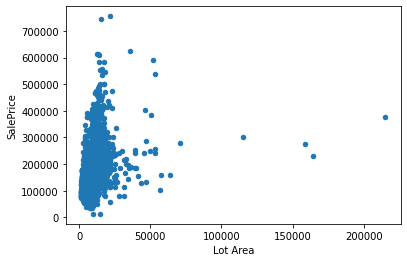

In [11]:
## this code is for running multiple runs
columns_to_drop = features_columns + [None]
for to_drop in columns_to_drop:
    if to_drop:
        dropped = df.drop(to_drop, axis=1)
    else:
        dropped = df
        
    with mlflow.start_run(run_name="second running") as run:
        print(run.info.run_id)
        prepared = prepare_data(dropped)
        mlflow.log_param("dropped", to_drop)
        train_and_evaluate(prepared)

In [26]:
## one run with multiples metricss
with mlflow.start_run(run_name="tercera running") as run:
    for to_drop in columns_to_drop:
        if to_drop:
            dropped = df.drop(to_drop, axis=1)
        else:
            dropped = df
        
        prepared = prepare_data(dropped)
        print(to_drop)
        #mlflow.log_param("dropped", to_drop) i can't do this, since in a simplem experiment 
        #i can't save miltiples parameters
        train_and_evaluate(prepared)

Lot Area
2686623332.3754606
Gr Liv Area
3980909422.5511055
Garage Area
3305431659.35769
Bldg Type
2854716346.360011
None
2662507570.636743


TypeError: log_model() got an unexpected keyword argument 'alias'

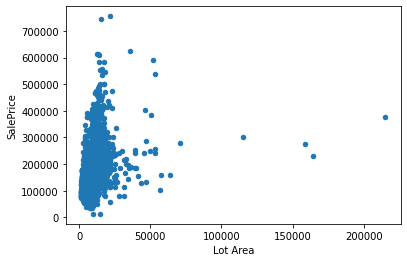

In [13]:
## now, i leave the multiples runs for focus on models registration
with mlflow.start_run(run_name='fifth logging model'):
    prepared, categorical_features_names = prepare_data(df)
    train_and_evaluate(prepared, categorical_features_names)

In [41]:
#delete my temportal folder
shutil.rmtree("tmp")

In [17]:
help(mlflow.pyfunc.log_model)

Help on function log_model in module mlflow.pyfunc:

log_model(artifact_path, loader_module=None, data_path=None, code_path=None, code_paths=None, infer_code_paths=False, conda_env=None, python_model=None, artifacts=None, registered_model_name=None, signature: mlflow.models.signature.ModelSignature = None, input_example: Union[pandas.core.frame.DataFrame, numpy.ndarray, dict, list, ForwardRef('csr_matrix'), ForwardRef('csc_matrix'), str, bytes, tuple] = None, await_registration_for=300, pip_requirements=None, extra_pip_requirements=None, metadata=None, model_config=None, example_no_conversion=False, streamable=None, resources: Union[str, List[mlflow.models.resources.Resource], NoneType] = None)
    Log a Pyfunc model with custom inference logic and optional data dependencies as an MLflow
    artifact for the current run.
    
    For information about the workflows that this method supports, see :ref:`Workflows for
    creating custom pyfunc models <pyfunc-create-custom-workflows>` and